In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class yolov1(nn.Module):

  def __init__(self, num_classes=1, B=2, S=7):
    super(yolov1, self).__init__()

    self.backbone = nn.Sequential(
            # Conv 1
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv 2
            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm2d(192),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv 3
            nn.Conv2d(192, 128, kernel_size=1, stride=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),

            # Conv 4
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),
            #nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv 5
            nn.Conv2d(256, 256, kernel_size=1, stride=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),

            # Conv 6
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),


            # Conv 7
            nn.Conv2d(512, 256, kernel_size=1, stride=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),

            # Conv 8
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(inplace=True),

            # Conv 9
            nn.Conv2d(512, 256, kernel_size=1, stride=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),

            # Conv 10
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(inplace=True),
            #nn.MaxPool2d(kernel_size=2, stride=2),

            #conv11
            nn.Conv2d(512, 256, kernel_size=1, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),

            #conv12
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1 ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(inplace=True),

            #conv13
            nn.Conv2d(512, 256, kernel_size=1, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),

            #conv14
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(inplace=True),

            # Conv 15
            nn.Conv2d(512, 512, kernel_size=1, stride=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(inplace=True),

            # Conv 16
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            # Conv 17
            nn.Conv2d(1024, 512, kernel_size=1, stride=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(inplace=True),

            # Conv 18
            nn.Conv2d(512, 1024, kernel_size=3, stride=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(inplace=True),

            #conv 19
            nn.Conv2d(1024, 512, kernel_size=1, stride=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(inplace=True),

            #conv 20
            nn.Conv2d(512, 1024, kernel_size=3, stride=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(inplace=True),

            #conv 21
            nn.Conv2d(1024, 1024, kernel_size=3, stride=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(inplace=True),

            #conv 22
            nn.Conv2d(1024, 1024, kernel_size=3, stride=2),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(inplace=True),

            #conv 23
            nn.Conv2d(1024, 1024, kernel_size=3, stride=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(inplace=True),

            #conv 24
            nn.Conv2d(1024, 1024, kernel_size=3, stride=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(inplace=True),
    )
    self.fc1 = nn.Linear(7*7*1024, 4096)
    self.fc2 = nn.Linear(4096, S * S * ( B * 5 + num_classes) )

  def forward(self, x):

      x = self.backbone(x)
      x = x.view(-1, 7*7*1024)
      x = nn.functional.leaky_relu(self.fc1(x))
      x = nn.functional.sigmoid(self.fc2(x))

      return x




In [39]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

class yolo(nn.Module):
    def __init__(self,loss=None, num_classes=1, S=7, B=2, yolobackbone=None):
        super(yolo, self).__init__()

        self.backbone = yolobackbone()
        # Define constants
        self.S = S
        self.B = B
        self.num_classes = num_classes


    def forward(self, images, targets=None):
        # Pass the input through the backbone network

        x = self.backbone(images)

        x = x.view(-1, self.S, self.S, self.B * 5 + self.num_classes)

        #print("inside the yolo class", sum(x))


        loss = self.calc_loss(x, targets, images)

        return loss

    def calc_loss(self, x, targets, images):

        data = output_preprocessing(x, targets, images)
        pred_offsets = data['stacked_pred']
        gt_offsets = data['stacked_gt']
        #print(pred_offsets)
        #print(gt_offsets)


        loss_xy = F.mse_loss(pred_offsets[:, :2], gt_offsets[:, :2], reduction='sum')



        pred_offsets_wh = torch.sign(pred_offsets[:, 2:4]) * torch.sqrt(torch.abs(pred_offsets[:,2:4]))
        gt_offsets_wh = torch.sqrt(gt_offsets[:, 2:4])

        loss_wh = F.mse_loss(pred_offsets_wh, gt_offsets_wh, reduction='sum')
        loss_offsets = (loss_wh + loss_xy)/gt_offsets_wh.numel() * 3
        ### classifier
        positive_scores = data["stacked_pos_scores"]
        positive_labels = data["stacked_pos_labels"]
        #print(positive_labels)
        #print(positive_scores)

        # classifier is set to zero when dealing with face detection
        classifier = F.mse_loss(positive_scores, positive_labels, reduction='sum') / positive_labels.numel() * 0.0

        ### positive objectness
        posi_object_labels = data["positive_obj_label"]
        posi_object_scores = data["positive_obj_scores"]
        obj_loss = F.mse_loss(posi_object_scores, posi_object_labels, reduction='sum') /posi_object_labels.numel() * 0.1
        #print("pos labels",posi_object_labels)
        #print("pos scores",posi_object_scores)
        ### negative objectness

        negi_object_labels = data["negative_obj_label"]
        negi_object_scores = data["negative_obj_score"]
        noobj_loss = F.mse_loss(negi_object_scores, negi_object_labels, reduction='sum') /negi_object_labels.numel() * 0.4
        #print(negi_object_labels)
        #print(negi_object_scores)
        #print(zz)


        return (classifier + loss_offsets + obj_loss + noobj_loss), classifier, loss_offsets, obj_loss, noobj_loss


In [40]:
from tqdm import tqdm
from functools import partial
tqdm = partial(tqdm, position=0, leave=True)
import torch
import numpy as np
import time
from PIL import Image
import matplotlib.pyplot as plt


def train_epocs(model, optimizer, data_loader, devie, epochs=10, training_state=False ):

    for epoch in range(epochs):
        if epoch==10:
           parameters = model.parameters()
           optimizer = torch.optim.SGD(parameters, lr = 0.000002,
                                       momentum=0.99)
        total = 0
        sum_loss = 0
        sum_loss_classifier = 0
        sum_loss_offsets = 0
        sum_loss_noobj = 0
        sum_loss_obj = 0

        iteration_num = 0

        for data in tqdm(data_loader):
            optimizer.zero_grad()
            images = data[0].to(device)
            targets = [ boxes.to(device) for boxes in data[2]]
            targets = torch.stack(targets)
            batch_length = len(images)
            ### gradient tracking
            if not training_state:
               with torch.no_grad():
                  model.eval()
                  output = model(images, targets)
            else:
                 model.train()
                 output = model(images, targets)
            Final_loss = output[0]
            if training_state:
               optimizer.zero_grad()
               Final_loss.backward()
               optimizer.step()
            iteration_num += 1
            total += batch_length

            sum_loss += Final_loss
            sum_loss_classifier += output[1]
            sum_loss_offsets += output[2]
            sum_loss_noobj += output[4]
            sum_loss_obj += output[3]

            if iteration_num % 50 == 0:

                train_loss = sum_loss/total
                train_loss_classifier = sum_loss_classifier/total
                train_loss_offsets = sum_loss_offsets/total
                train_loss_noobj = sum_loss_noobj/total
                train_loss_obj = sum_loss_obj/total
                print("loss %.6f classifer %.6f regressor %.6f noobj_loss %.6f obj_loss %.6f "%
                      (train_loss, train_loss_classifier, train_loss_offsets, train_loss_noobj, train_loss_obj))
                total = 0.0
                sum_loss= 0.0
                sum_loss_classifier = 0.0
                sum_loss_offsets = 0.0
                sum_loss_noobj = 0.0
                sum_loss_obj = 0.0


    return model


In [27]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = yolo(yolobackbone=yolov1).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4 , momentum = 0.99)
print(device)


cpu


In [ ]:
torch.sa ve(model.state_dict(), '/content/gdrive/MyDrive/yolov1new1.pth')





In [28]:
model.load_state_dict(torch.load('/content/gdrive/MyDrive/yolov1new1.pth', map_location=device))






<All keys matched successfully>

In [ ]:
train = train_epocs(model, optimizer, data_loader, device,  training_state=False)




In [26]:
def output_preprocessing(pred_offsets, gt_bboxes, images):
    stacked_gt = []
    stacked_pred = []
    stacked_positive_labels = []
    stacked_positive_scores = []

    stacked_positive_obj_label = []
    stacked_positive_obj_score = []

    stacked_negative_obj_label = []
    stacked_negative_obj_scores = []


    assinged_indices = []
    objectness_score = []
    target_objectness = []
    stacked_class_score = []
    labels = []
    for pred, gt in zip(pred_offsets, gt_bboxes):

      converted_pred_bboxes = convertOffsets_into_pred_boxes(pred.detach().clone())
      converted_gt_bboxes = convertOffsets_into_pred_boxes(gt.detach().clone())



      gt_loc = gt[:,:,-1].nonzero()
      neg = torch.where(gt[:, : ,-1]==0)

      stacked_negative_obj_label.append( torch.stack( (gt[neg][:,-1], gt[neg][:,-1] ) ).view(-1) )


      stacked_negative_obj_scores.append( torch.stack( (pred[neg][:,4] , pred[neg][:,9] )).view(-1) )

      '''
      draw = []
      values, indices = torch.topk(pred[:,:,4].view(-1), k=30, largest=True)
      values2, indices2 = torch.topk(pred[:,:,9].view(-1), k=30, largest=True)
      for num in range(len(gt_loc)):
       if values[num]>values2[num]:
         print("values",values)
         indi= indices
         draw.append(converted_pred_bboxes.view(49,-1)[indi[num], 0:4].view(-1,4))
       else:
         print("values2",values2)
         indi=indices2
         draw.append(converted_pred_bboxes.view(49,-1)[indi[num], 5:9].view(-1,4))
      draw = torch.stack(draw).view(-1,4)


      img = images[1].to(torch.device('cpu')).numpy().transpose(1,2,0).copy()
      for d in draw:
        d = convertxywhtoxyxy(d.view(-1,4)).view(4)
        print("draw is", d)
        x1 = int(d[0])
        y1 = int(d[1])
        x2 = int(d[2])
        y2 = int(d[3])
        cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)
      '''

      for loc in gt_loc:

          targeted_pred = converted_pred_bboxes[loc[0],loc[1],:]
          target_bboxes = converted_gt_bboxes[loc[0], loc[1], :-1]

          stacked_gt.append(gt[ loc[0], loc[1], :-1])

          stacked_positive_labels.append(gt[loc[0], loc[1], -1])
          stacked_positive_scores.append(pred[loc[0], loc[1], -1])


          stacked_positive_obj_label.append(gt[loc[0], loc[1], -1])

          bboxes_to_calc_iou = torch.stack((targeted_pred[:4], targeted_pred[5:9]))

          bboxes_to_calc_iou = convertxywhtoxyxy(bboxes_to_calc_iou)
          target_bboxes = convertxywhtoxyxy(target_bboxes.view(1, -1))

          '''
          tar = target_bboxes.view(-1)
          x1 = int(tar[0])
          y1 = int(tar[1])
          x2 = int(tar[2])
          y2 = int(tar[3])
          cv2.rectangle(img, (x1, y1), (x2, y2), (2,255,0), 2)
          plt.imshow(img)
          print("target boxes", target_bboxes)
          '''

          iou = calc_iou(bboxes_to_calc_iou, target_bboxes)

          if iou[0]>iou[1]:

             stacked_pred.append(pred[loc[0], loc[1], 0:4])
             stacked_positive_obj_score.append(pred[loc[0], loc[1],4])

          elif iou[0]<iou[1]:

             stacked_pred.append(pred[loc[0], loc[1], 5:9])
             stacked_positive_obj_score.append(pred[loc[0], loc[1],9])

          else:

             stacked_pred.append(pred[loc[0], loc[1], 0:4])
             stacked_positive_obj_score.append(pred[loc[0], loc[1], 4])


    return {"stacked_gt":torch.stack(stacked_gt), "stacked_pred":torch.stack(stacked_pred),
            "stacked_pos_labels":torch.stack(stacked_positive_labels).view(-1),
            "stacked_pos_scores":torch.stack(stacked_positive_scores).view(-1),
            "positive_obj_label":torch.stack(stacked_positive_obj_label).view(-1),
            "positive_obj_scores": torch.stack(stacked_positive_obj_score).view(-1),
            "negative_obj_label": torch.cat(stacked_negative_obj_label).view(-1),
            "negative_obj_score": torch.cat(stacked_negative_obj_scores).view(-1)}


In [5]:
def convertxywhtoxyxy(input):
    buffer_box = input.clone()
    boxes = input.clone()

    boxes[:,0] = buffer_box[:,0] - buffer_box[:,2]/2
    boxes[:,1] = buffer_box[:,1] - buffer_box[:,3]/2
    boxes[:,2] = buffer_box[:,0] + buffer_box[:,2]/2
    boxes[:,3] = buffer_box[:,1] + buffer_box[:,3]/2

    return boxes

In [6]:
def convertOffsets_into_pred_boxes( offsets):

    new_offsets = torch.zeros_like(offsets, device=offsets.device)
    for j in range(7):
       for i in range(7):
          if offsets.size(2)==11:
            new_offsets[j,i,0:2] = offsets[j,i,0:2] * 64 + torch.tensor([i,j], device= offsets.device) * 64
            new_offsets[j,i,2:4] = offsets[j,i,2:4] * 448
            new_offsets[j,i,5:7] = offsets[j,i,5:7] * 64 + torch.tensor([i,j], device=offsets.device) * 64
            new_offsets[j,i,7:9] = offsets[j,i,7:9] * 448
          else:
            new_offsets[j,i,0:2] = offsets[j,i,0:2] * 64 + torch.tensor([i,j], device = offsets.device) * 64
            new_offsets[j,i,2:4] = offsets[j,i,2:4] * 448

    return new_offsets



In [7]:
def calc_iou(pred_boxes, gt_boxes):
    pred_boxes_area = (pred_boxes[:,2] - pred_boxes[:,0]) * (pred_boxes[:,3] - pred_boxes[:,1])
    gt_area = (gt_boxes[:,2] - gt_boxes[:,0]) * (gt_boxes[:,3] - gt_boxes[:,1])

    upper_left_intersection = torch.max(pred_boxes[:,:2].unsqueeze(1), gt_boxes[:,:2])
    lower_right_intersection = torch.min(pred_boxes[:, 2:].unsqueeze(1), gt_boxes[:,2:])
    intersection_dimension = (lower_right_intersection - upper_left_intersection).clamp(min=0)
    intersection_area = intersection_dimension[:,:,0] * intersection_dimension[:,:,1]
    union_areas = pred_boxes_area.unsqueeze(1) + gt_area - intersection_area
    return intersection_area/union_areas





In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
!unzip /content/gdrive/MyDrive/wider_face_split.zip


Archive:  /content/gdrive/MyDrive/wider_face_split.zip
   creating: wider_face_split/
  inflating: wider_face_split/readme.txt  
  inflating: wider_face_split/wider_face_test.mat  
  inflating: wider_face_split/wider_face_test_filelist.txt  
  inflating: wider_face_split/wider_face_train.mat  
  inflating: wider_face_split/wider_face_train_bbx_gt.txt  
  inflating: wider_face_split/wider_face_val.mat  
  inflating: wider_face_split/wider_face_val_bbx_gt.txt  


In [ ]:
!unzip /content/gdrive/MyDrive/WIDER_train.zip

In [11]:
from PIL import Image
import torchvision
import numpy as np
import cv2
import torch

class LoadDataSet(torch.utils.data.Dataset):
      def __init__(self, annotation_path, images_path, transforms):
          self.images_path_list = images_path
          self.annotations_path_list = annotation_path
          self.transform = transforms
          self.size = len(self.images_path_list)
          print(self.size)
      def __getitem__(self, idx):
          Transform = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                       std=[0.229, 0.224, 0.225])

          img_path = '/content/WIDER_train/images/'+self.images_path_list[idx]
          gt_boxes = self.annotations_path_list[idx]
          img = Image.open(img_path)
          img = np.asarray(img)
          img_size = img.shape
          image = cv2.resize(img/255., (448, 448), interpolation=cv2.INTER_AREA)
          image = torch.as_tensor(image, dtype=torch.float32).permute(2,0,1)
          image = Transform(image)
          scalar = torch.tensor([1, 448/img_size[1], 448/img_size[0], 448/img_size[1], 448/img_size[0]], dtype=torch.float32)

          T = torch.zeros(7, 7, 5)
          boxes = []
          scale_ratio = 64
          for box in gt_boxes:
              s_box = torch.tensor(box, dtype=torch.float32)*scalar

              boxes.append(s_box)
              cls = s_box[0]
              x = (s_box[1] + s_box[3])/2


              x_ctr = int(x/scale_ratio)
              x = (x - (x_ctr*scale_ratio))/64

              y = (s_box[2] + s_box[4])/2

              y_ctr = int(y/scale_ratio)
              y = (y - (y_ctr*scale_ratio))/64

              w = (s_box[3] - s_box[1])/448
              h = (s_box[4] - s_box[2])/448


              T[int(y_ctr), int(x_ctr), 0] = x
              T[int(y_ctr), int(x_ctr), 1] = y
              T[int(y_ctr), int(x_ctr), 2] = w
              T[int(y_ctr), int(x_ctr), 3] = h
              T[int(y_ctr), int(x_ctr), 4] = cls
              #T[int(y_ctr), int(x_ctr), 10] = cls

          boxes = torch.stack(boxes)

          return image, boxes, T

      def __len__(self):
          return self.size
def collate_fn(batch):
    images = []
    boxes = []
    T = []

    for data in batch:
        images.append(data[0])
        boxes.append(data[1])
        T.append(data[2])
    return torch.stack(images, dim=0), boxes, torch.stack(T, dim=0)







In [74]:
file = open('/content/wider_face_split/wider_face_train_bbx_gt.txt')
lista=[]
inside_list=[]
names=[]
triger=0

for idx, line in enumerate(file.readlines()):
    if line[-4:]=="jpg\n":
       names.append(line[:-1])
       if (inside_list==[] or triger==1) and idx!=0:
          names.pop(len(names)-2)
          inside_list = []
          triger = 0
          continue
       if idx!=0 and inside_list!=[]:
          lista.append(inside_list)
          inside_list = []
    if line[-4:]!='jpg\n' and len(line)>15:
       num_list = line.strip()
       num_str = num_list.split()
       x1 = int(num_str[0])
       y1 = int(num_str[1])
       x2 = int(num_str[0]) + int(num_str[2])
       y2 = int(num_str[1]) + int(num_str[3])
       if num_str[2]!='0' and num_str[3]!='0' and num_str[7]!='1' and (x2-x1)>60 and (x2-x1)<1200 and (y2-y1)>60 and (y2-y1)<1200:
          array_int = [1, x1, y1, x2, y2]
          inside_list.append(array_int)
       else:
          triger=1
    if idx == 185183:
       if inside_list!=[] and triger==0:
          lista.append(inside_list)
       elif inside_list==[] and triger==1:
          names.pop()


In [75]:
#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
dataset = LoadDataSet(annotation_path=lista, images_path=names, transforms=None)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn, drop_last=True)


5858


tensor([[0, 1, 2],
        [0, 1, 3],
        [0, 1, 4],
        [1, 2, 2],
        [1, 2, 5]])
tensor([  1.0000, 112.8750,  52.4317, 152.2500, 111.8544])
tensor([  1.0000, 199.5000,  47.7711, 231.0000, 106.0286])
tensor([  1.0000, 253.7500,  73.4044, 295.7500, 130.4967])


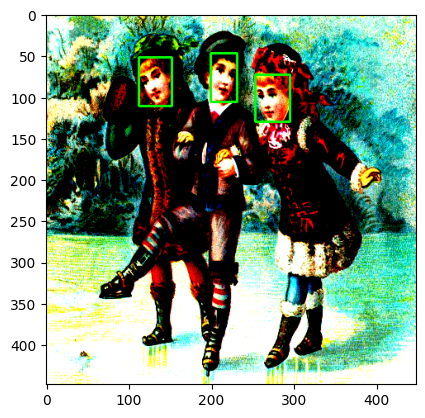

In [99]:
n = 0
anno = 0
import matplotlib.pyplot as plt
for i, (images, annotations, t) in enumerate(data_loader):
  if i == 4:
    print(t[:, :, :, 4].nonzero())
    n = t[0]
    #anno= torch.stack(annotations, dim=0)

    img = images[0].numpy().transpose(1,2,0).copy()
    for box in annotations[0]:
        print(box)
        x1 = int(box[1])
        y1 = int(box[2])
        x2 = int(box[3])
        y2 = int(box[4])
        cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0),2)
    plt.imshow(img)
    break




